# 使用Colab時執行下面程式

In [1]:
# !/opt/bin/nvidia-smi

In [2]:
# from google.colab import drive
# import pandas as pd
# drive.mount('/content/gdrive') # 此處需要登入google帳號

In [3]:
# ! cp '/content/gdrive/MyDrive/data/cats_and_dogs_small.zip' .
# ! unzip -o 'cats_and_dogs_small.zip'

# 初始宣告

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from tqdm import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode
torch.__version__

'2.4.0+cu121'

In [2]:
base_dir = 'D:\\VGGKANGAROO'
train_dir = base_dir + '/train';
validation_dir = base_dir + '/valid'
test_dir = base_dir + '/test'
train_cats_dir = train_dir + '/kangaroo'
train_dogs_dir = train_dir + '/wallaby'
validation_cats_dir = validation_dir + '/kangaroo'
validation_dogs_dir = validation_dir + '/wallaby'
test_cats_dir = test_dir + '/kangaroo'
test_dogs_dir = test_dir + '/wallaby'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device_name

'cuda'

# 載入影像資料

In [4]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

train_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomAffine(degrees=40,translate=(0.2,0.2),scale=(1,1.2)),
  transforms.Resize((150,150)),
  transforms.ToTensor()
])

validation_transform = transforms.Compose([
  transforms.Resize((150,150)),
  transforms.ToTensor()
])
train_dataset = datasets.ImageFolder(train_dir, train_transform)
validation_dataset = datasets.ImageFolder(validation_dir, validation_transform)
print('train_dataset = ',train_dataset)
print('validation_dataset = ',validation_dataset)
print('class label = ', train_dataset.classes)

train_dataset =  Dataset ImageFolder
    Number of datapoints: 2643
    Root location: D:\VGGKANGAROO/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-40.0, 40.0], translate=(0.2, 0.2), scale=(1, 1.2))
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
validation_dataset =  Dataset ImageFolder
    Number of datapoints: 411
    Root location: D:\VGGKANGAROO/valid
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
class label =  ['kangaroo', 'wallaby']



# 建立模型

In [5]:
model = models.vgg16(weights='IMAGENET1K_V1')
# model = nn.Sequential(
#     model,
#     nn.Linear(1000, 2)
# )

num_ftrs = model.classifier[6].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.classifier[6] = nn.Linear(num_ftrs, 2)



model = model.to(device)

from torchsummary import summary
summary(model, (3,150,150), device=device_name)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

# 訓練模型

In [6]:
def train_model(model, train_dataset, val_dataset, criterion, optimizer, scheduler=None, num_epochs=200, use_amp=False):
    image_datasets = {
        'train': train_dataset,
        'val': val_dataset
    }
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=4, pin_memory=True) 
                   for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    score = {'train':{'loss': [],'acc': []}, 'val':{'loss': [],'acc': []}}
    
    since = time.time()
    
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        try:
                            with torch.cuda.amp.autocast(enabled=use_amp):
                                outputs = model(inputs)
                                _, preds = torch.max(outputs, 1)
                                loss = criterion(outputs, labels)
                                
                            if phase == 'train':
                                scaler.scale(loss).backward()
                                scaler.step(optimizer)
                                scaler.update()

                        except RuntimeError as e:
                            if 'out of memory' in str(e):
                                print("WARNING: Out of memory. Adjusting batch size...")
                                torch.cuda.empty_cache()
                                dataloaders[phase] = torch.utils.data.DataLoader(
                                    image_datasets[phase], 
                                    batch_size=max(1, dataloaders[phase].batch_size // 2), 
                                    shuffle=True, 
                                    num_workers=4, 
                                    pin_memory=True
                                )
                            else:
                                raise e

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train' and scheduler is not None:
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                score[phase]['loss'].append(epoch_loss)
                score[phase]['acc'].append(epoch_acc.item())
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model, score

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = None

model, score = train_model(model, train_dataset, validation_dataset, 
                           criterion, optimizer, exp_lr_scheduler, num_epochs=200)

C:\Users\User\AppData\Local\Temp\ipykernel_2496\949262669.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Epoch 1/200
----------


  0%|                                                                                         | 0/2643 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_2496\949262669.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
 16%|████████████▎                                                                  | 410/2643 [00:22<02:01, 18.40it/s]


OSError: Caught OSError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\_utils\worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\datasets\folder.py", line 245, in __getitem__
    sample = self.loader(path)
             ^^^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\datasets\folder.py", line 284, in default_loader
    return pil_loader(path)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\datasets\folder.py", line 264, in pil_loader
    return img.convert("RGB")
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py", line 995, in convert
    self.load()
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\ImageFile.py", line 290, in load
    raise OSError(msg)
OSError: image file is truncated (20 bytes not processed)


In [ ]:
torch.save(model, 'VGGKANGAROO.pt')

## 檢視效能

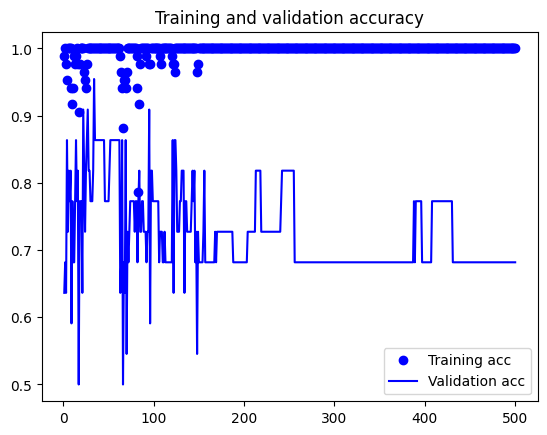

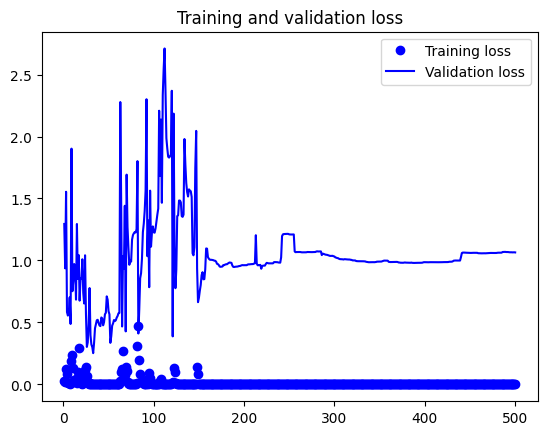

In [22]:
import matplotlib.pyplot as plt
acc = score['train']['acc']
val_acc = score['val']['acc']
loss = score['train']['loss']
val_loss = score['val']['loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 測試

In [23]:
# model = keras.models.load_model('/content/gdrive/MyDrive/model/DNN_貓狗分類.h5')
model = torch.load('VGGKANGAROO.pt')

C:\Users\User\AppData\Local\Temp\ipykernel_19844\45020041.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('VGGKANGAROO.pt')


In [24]:
# 檢查模型輸出的類別對應關係
print('class label = ', train_dataset.classes)

class label =  ['kangaroo', 'wallaby']


<>:2: SyntaxWarning: invalid escape sequence '\k'
<>:2: SyntaxWarning: invalid escape sequence '\k'
C:\Users\User\AppData\Local\Temp\ipykernel_19844\974552668.py:2: SyntaxWarning: invalid escape sequence '\k'
  img = Image.open('D:\\VGGKANGAROO\kangaroo1.jpg')


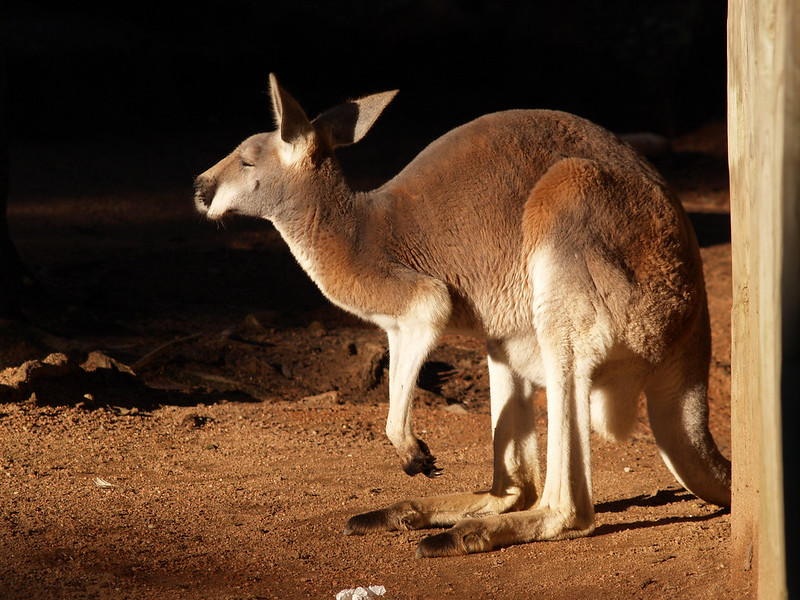

In [26]:
# img = Image.open(test_cats_dir+'/cat.1502.jpg').convert('RGB')  # 0~255
img = Image.open('D:\\VGGKANGAROO\kangaroo1.jpg')
img

In [28]:
#將影像轉換成Tensor
input_tensor = validation_transform(img).unsqueeze(0).to(device)

#將影像轉換成Tensor, 方法2
# input_tensor = transforms.ToTensor()(transforms.Resize((150,150))(img)).unsqueeze(0).to(device)

predictions = model(input_tensor)
print('predictions = ',predictions)

score = torch.sigmoid(predictions[0][0])
print(f"This image is {100 * score:.2f}% kangaroo and {100 * (1-score):.2f}% wallaby.")

predictions =  tensor([[ 0.5249, -0.4363]], device='cuda:0', grad_fn=<AddmmBackward0>)
This image is 62.83% kangaroo and 37.17% wallaby.
